In [11]:
import pandas as pd
import numpy as np 
from datetime import timedelta
import datetime as dt
from scipy import signal 
import holidays
import sys
sys.path.append('../lib/')
from utils import *
from analysis import * 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

In [28]:
data = pd.read_csv("../Data/daneOkresoweKSE.csv", sep=';', 
                   skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = data.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)
Electric.loc[Electric.Hour == 24, 
             'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0
Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + 
                               Electric['Hour'].astype(str) + ':' + 
                               Electric.Minute.astype(str) + ':00')

Electric = Electric[['Date', 'Load']]
Electric['Minutes'] = Electric['Date'].dt.minute
Electric['Hour'] = Electric['Date'].dt.hour

In [62]:
Electric

,Date,Load,Minutes,Hour,holiday,Day
0,2008-01-01 00:15:00,15938.8,15,0,NaN,1
1,2008-01-01 00:30:00,15770.4,30,0,NaN,1
2,2008-01-01 00:45:00,15766.3,45,0,NaN,1
3,2008-01-01 01:00:00,15415.2,0,1,NaN,1
4,2008-01-01 01:15:00,15351.8,15,1,NaN,1
...,...,...,...,...,...,...
315643,2016-12-31 23:00:00,15952.7,0,23,NaN,5
315644,2016-12-31 23:15:00,15865.3,15,23,NaN,5
315645,2016-12-31 23:30:00,15693.5,30,23,NaN,5
315646,2016-12-31 23:45:00,15508.3,45,23,NaN,5


<AxesSubplot:>

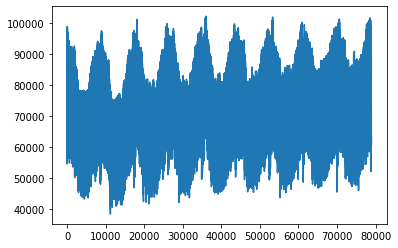

In [4]:
df = resampling_data(Electric)

df = df[~df.Load.isna()].reset_index(drop=True)
df['Load'].plot()

In [5]:
df['Load_lin'] = linear_fit(x=df.index, y=df.Load)
df['Load_detrend'] = df.Load - df['Load_lin']

df

,Date,Hour,Minutes,Load,Day,Holiday,Day id,Load_lin,Load_detrend
0,2008-01-01 01:00:00,1.0,22.5,60819.9,1,True,1,68781.328648,-7961.428648
1,2008-01-01 02:00:00,2.0,22.5,57869.8,1,True,1,68781.407929,-10911.607929
2,2008-01-01 03:00:00,3.0,22.5,55672.8,1,True,1,68781.487211,-13108.687211
3,2008-01-01 04:00:00,4.0,22.5,55331.7,1,True,1,68781.566492,-13449.866492
4,2008-01-01 05:00:00,5.0,22.5,54527.0,1,True,1,68781.645773,-14254.645773
...,...,...,...,...,...,...,...,...,...
78907,2016-12-31 20:00:00,20.0,22.5,70390.3,5,False,366,75037.169791,-4646.869791
78908,2016-12-31 21:00:00,21.0,22.5,66925.1,5,False,366,75037.249072,-8112.149072
78909,2016-12-31 22:00:00,22.0,22.5,64900.1,5,False,366,75037.328354,-10137.228354
78910,2016-12-31 23:00:00,23.0,22.5,63019.8,5,False,366,75037.407635,-12017.607635


In [6]:
def add_linear_term(df, new_col='Load', detrend_col='Load_detrend', lin_col='Load_lin'):
    """Lin_column must be the first column.

    Args:
        df (_type_): _description_
        lin_column (str, optional): _description_. Defaults to 'Load_lin'.
    """
    for column in df.columns:
        df[column] += df[lin_col]
    
    del df[lin_col]
    df.columns = df.columns.str.replace(detrend_col, new_col)

    return df


def psf_forecasting(df, feature='Load_detrend', cut_day='2016-12-22'):
    train_set = df[df.Date <= pd.to_datetime(cut_day, format='%Y-%m-%d')].copy()
    test_set = df[df.Date >= pd.to_datetime(cut_day, format='%Y-%m-%d')].copy()
    n_days_ahead = len(test_set.Date.dt.day_of_year.unique())
    
    working_days = train_set[~train_set.Holiday].reset_index(drop=True)
    festivities = train_set[train_set.Holiday].reset_index(drop=True)
    
    f = {feature: ['mean', q1, q2], 'Load_lin': ['mean', q1, q2]}
    pred_working_days = working_days.groupby(['Day', 'Hour']).agg(f)
    pred_festivities = festivities.groupby(['Day id', 'Hour']).agg(f)    

    forecasting = []
    for day in pd.date_range(cut_day, periods=n_days_ahead, freq="d"):
        if any(day.day_of_year == festivities['Day id']):
            forecasting.append(pred_festivities.loc[day.day_of_year][feature].to_numpy())
        else:
            forecasting.append(pred_working_days.loc[day.day_of_week][feature].to_numpy())

    forecasting = np.concatenate(forecasting)
    
    tmp = df[['Date', 'Load_lin', 'Load_detrend']].copy()
    n = len(forecasting) - len(test_set)

    tmp.loc[tmp.Date > cut_day,
            ['forecast', 'q1_forecast', 'q2_forecast']] = forecasting[:-n-1, :]
    tmp.set_index('Date', inplace=True)

    return add_linear_term(tmp)

In [7]:
def plot_psf_forecasting(df, cut_day, feature = 'Load'):
    
    date = pd.to_datetime(cut_day) - dt.timedelta(weeks=2)
    n_days = (pd.to_datetime(df.index[-1]) - pd.to_datetime(cut_day)).days
    cut_mask = df.index > cut_day
    date_mask = df.index > date
 
    ax = latex_settings()
    df.loc[date_mask, [feature]].plot(ax=ax, color='b', lw=1)
    df.loc[cut_mask, [feature, 'forecast']].plot(ax=ax, color=['g', 'orange'], lw=1)
    plt.fill_between(x=df[date_mask].index, y1=df[date_mask].q1_forecast,
                    y2=df[date_mask].q2_forecast, color='orange', alpha=0.5, lw=1)
    plt.grid()
    plt.ylabel('Load (MW)')
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.title(f'Poland Electricity Load ({n_days} days)')
    leg = plt.legend(loc="lower left", ncol=4, fancybox=True, framealpha=0.5,
                     fontsize=7.5,
                     labels=['Train set', 'Test set', 'Forecast', '95% CI'])

    #plt.savefig(f'../Images/PSF_forecasting_{n_days}days.png', dpi=800, transparent=True)

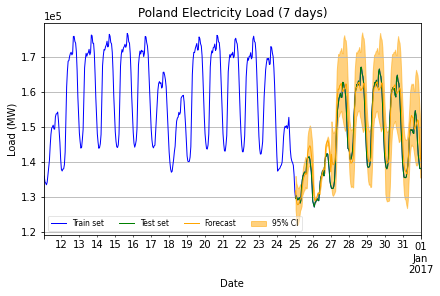

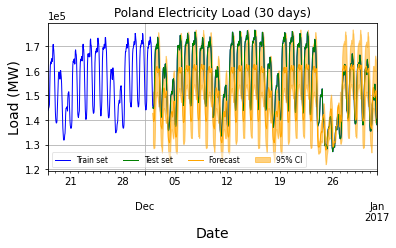

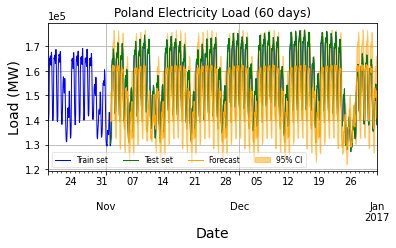

In [8]:
cut_dates = ['2016-12-25', '2016-12-02', '2016-11-02'] 

dfs = []
for cut_date in cut_dates:
    tmp = psf_forecasting(df, cut_day=cut_date)
    plot_psf_forecasting(tmp, cut_date)
    dfs.append(tmp)

In [ ]:
df_day =  resampling_data(Electric, resample_cost='d')

df_day = df_day[~df_day.Load.isna()].reset_index(drop=True)
df_day['Load_lin'] = linear_fit(x=df_day.index, y=df_day.Load)
df_day['Load_detrend'] = df_day.Load - df_day['Load_lin']

In [9]:
for df in dfs:
    x, y = df.loc[~df.isna().any(axis=1), ['Load', 'forecast']].to_numpy().T
    print(mse(x, y))

15737232.872676833
80615918.99906321
75546823.57933728
